# SIGNAL PROCESSING TP1 - M2 AI
## To Do: Guitar tuner

- Benedictus Kent Rachmat
- Jacobo Ruiz Ocampo

In [1]:
# install the library if needed
# !pip install -qU scipy matplotlib librosa opencv-python

---

In this TP, we implemented 2 method: 
- Method 1: Finding the widest and tallest peak
- Method 2: Harmonic Product Spectrum (HPS) approach

The table below showcases the results of both methods. It's evident from the data that Method 2 (HPS) yields superior results compared to Method 1. Please scroll down for more details.

| Dominant Frequency (Hz) Method 1 | Accuracy (in cent) Method 1 | Dominant Frequency (Hz) Method 2 | Accuracy (in cent) Method 2 | Note Frequency (Hz) | Note |
|----------------------------------|-----------------------------|-------------------------|---------------------|---------------------|------|
| 196.64                           | 4.24                        | 195.98                  | 0.13                | 196.0               | G3   |
| 110.21                           | 2.65                        | 110.12                  | 1.53                | 110.0               | A5   |
| 329.78                           | 0.98                        | 329.68                  | 0.34                | 329.63              | E1   |

## IMPORT

In [2]:
import librosa
import warnings
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from scipy.signal import peak_widths, find_peaks

## Method 1: Finding the widest and tallest peak
First we searched for the widest peaks (we picked 0.25 of the prominence height) then we filter out to find the tallest among them.

In [3]:
# List of Accuracy Cents
accuracy_cents = [0.15, 0.15, 0.15, 0.08, 0.08, 0.04]

# List of Note Frequencies
note_frequencies = [329.63, 246.94, 196.0, 146.83, 110.0, 82.41]

# List of Note Names
note_names = ['E1', 'B2', 'G3', 'D4', 'A5', 'E6']

# Top N peak to be selected
TOP_PEAK = 10

In [4]:
def spectral_analysis(file_name):
    """
    Perform spectral analysis on an audio signal to identify the dominant frequency.

    Parameters:
    ----------
    - file_name : str
        The name of the audio file to analyze.

    Returns:
    ----------
    None
    """
    # Load the audio file and get the sample rate
    audio_signal, sample_rate = librosa.load(file_name)
    
    # Perform FFT on the audio signal
    x1_fft = np.fft.fft(audio_signal)
    
    # Calculate key parameters
    N = len(audio_signal)
    Fs = sample_rate
    Freq = np.linspace(-Fs/2, Fs/2, N)
    
    # Compute the power spectrum peaks
    x1_spectrum = np.fft.fftshift(np.abs(x1_fft) ** 2)
    peak_indices = np.argpartition(-x1_spectrum, TOP_PEAK)[:TOP_PEAK]
    
    # Calculate and locate the widest peak
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        peak_width = peak_widths(x1_spectrum, peak_indices, rel_height=0.25)

    # Search for the dominant frequency
    widest_peak_index = peak_indices[np.argmax(peak_width[0])]
    dominant_frequency = np.abs(Freq[widest_peak_index])
    
    # Print information about the dominant frequency and accuracy in cent
    index, difference = find_closest_value(dominant_frequency, note_frequencies)
    cents_difference = difference / accuracy_cents[index]

    print(f'Accuracy: {cents_difference:.2f} Cents')
    print(f'The note is {note_names[index]} ({note_frequencies[index]} Hz)')
    
    # Plot the power spectrum
    plt.figure(1)
    plt.xlim(-600, 600)

    plt.plot(Freq, x1_spectrum)
    plt.plot([-Freq[widest_peak_index], Freq[widest_peak_index]], [x1_spectrum[widest_peak_index]]*2, "x", markersize=8)  
    
    plt.title(f'Power Spectrum (Dominant Frequency: {dominant_frequency:.2f} Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.show()

    return audio_signal,sample_rate

def find_closest_value(target_value, value_vector):
    """
    Finds the index and absolute difference of the closest value.

    Parameters:
    ----------
    target_value : float
        The value for which we want to find the closest match in the list.
    
    value_vector : list
        The note frequencies.
    
    Returns:
    -------
    closest_index : int
        The index of the closest value.
    
    absolute_difference : float
        The absolute difference of the closest value.
    """
    
    # Calculate absolute differences between target_value and values in value_vector
    absolute_differences = np.abs(value_vector - target_value)

    # Find the index of the closest value
    closest_index = np.argmin(absolute_differences)

    return closest_index, absolute_differences[closest_index]

Accuracy: 0.98 Cents
The note is E1 (329.63 Hz)


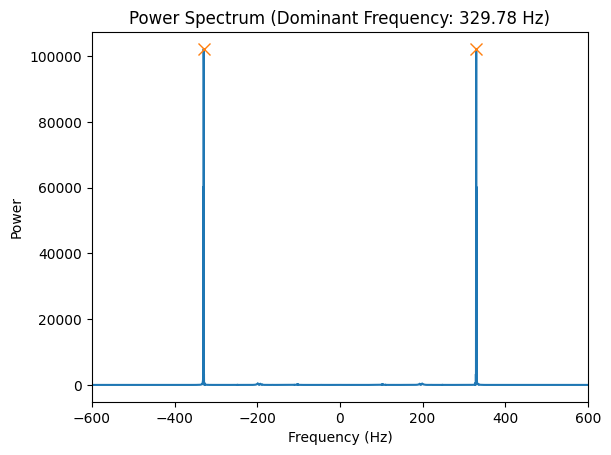

In [5]:
audio_signal,sample_rate = spectral_analysis('string_e.wav')
ipd.Audio(audio_signal, rate=sample_rate)

Accuracy: 2.65 Cents
The note is A5 (110.0 Hz)


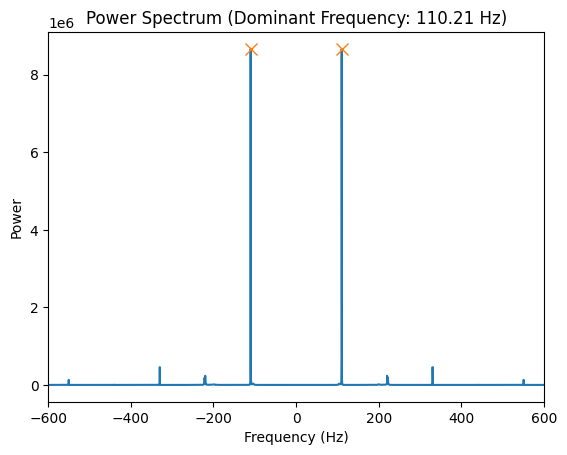

In [6]:
audio_signal,sample_rate = spectral_analysis('string_a.wav')
ipd.Audio(audio_signal, rate=sample_rate)

Accuracy: 4.24 Cents
The note is G3 (196.0 Hz)


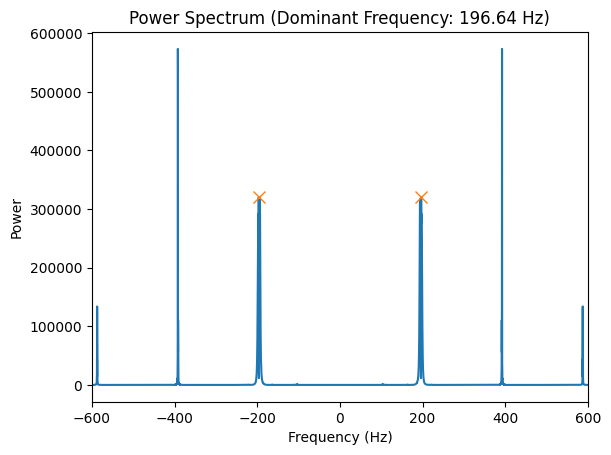

In [7]:
audio_signal,sample_rate = spectral_analysis('string_g.wav')
ipd.Audio(audio_signal, rate=sample_rate)

---

## Method 2: Harmonic Product Spectrum (HPS)
This method is a pitch detection method that's particularly effective for monophonic signals (1 channel).

In [8]:
def hps(filename, downsampling_factors=[2, 3, 4, 5]):
    """
    Detect the pitch of an audio file using the HPS method and plot spectra for each factor.
    
    Parameters:
    ----------
    - filename : str
        The path to the audio file to be analyzed.
        
    - downsampling_factors : list
        The factors by which the magnitude spectrum should be downsampled.
    
    Returns:
    ----------
    - peak_freq : float
        The frequency in Hz corresponding to the most prominent peak in 
        the product spectrum.
    """

    audio_signal, sample_rate = librosa.load(filename)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(np.fft.fft(audio_signal))
    frequencies = np.fft.fftfreq(len(audio_signal), 1/sample_rate)
    
    # Plot the original and downsampled magnitude spectra for each factor
    plt.figure(figsize=(10, 15))

    # Original spectrum
    plt.subplot(len(downsampling_factors) + 1, 1, 1)
    plt.plot(frequencies, magnitude_spectrum)
    plt.title(f"Original Magnitude Spectrum of {filename}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.xlim(0, 5000)

    # Downsampled spectra
    for i, factor in enumerate(downsampling_factors, 2):
        plt.subplot(len(downsampling_factors) + 1, 1, i)
        downsampled_spectrum = magnitude_spectrum[:factor*(len(magnitude_spectrum)//factor):factor]
        plt.plot(frequencies[:len(downsampled_spectrum)], downsampled_spectrum)
        plt.title(f"Downsampled Spectrum (Factor: {factor})")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        plt.xlim(0, 5000)
    
    plt.tight_layout()
    plt.show()

    # Compute the product spectrum
    product_spectrum = np.ones_like(magnitude_spectrum)
    for factor in downsampling_factors:
        product_spectrum[:len(magnitude_spectrum)//factor] *= magnitude_spectrum[:factor*(len(magnitude_spectrum)//factor):factor]

    # Find the peak in the product spectrum
    peaks, _ = find_peaks(product_spectrum)
    peak_freq = frequencies[peaks[np.argmax(product_spectrum[peaks])]]

    return peak_freq

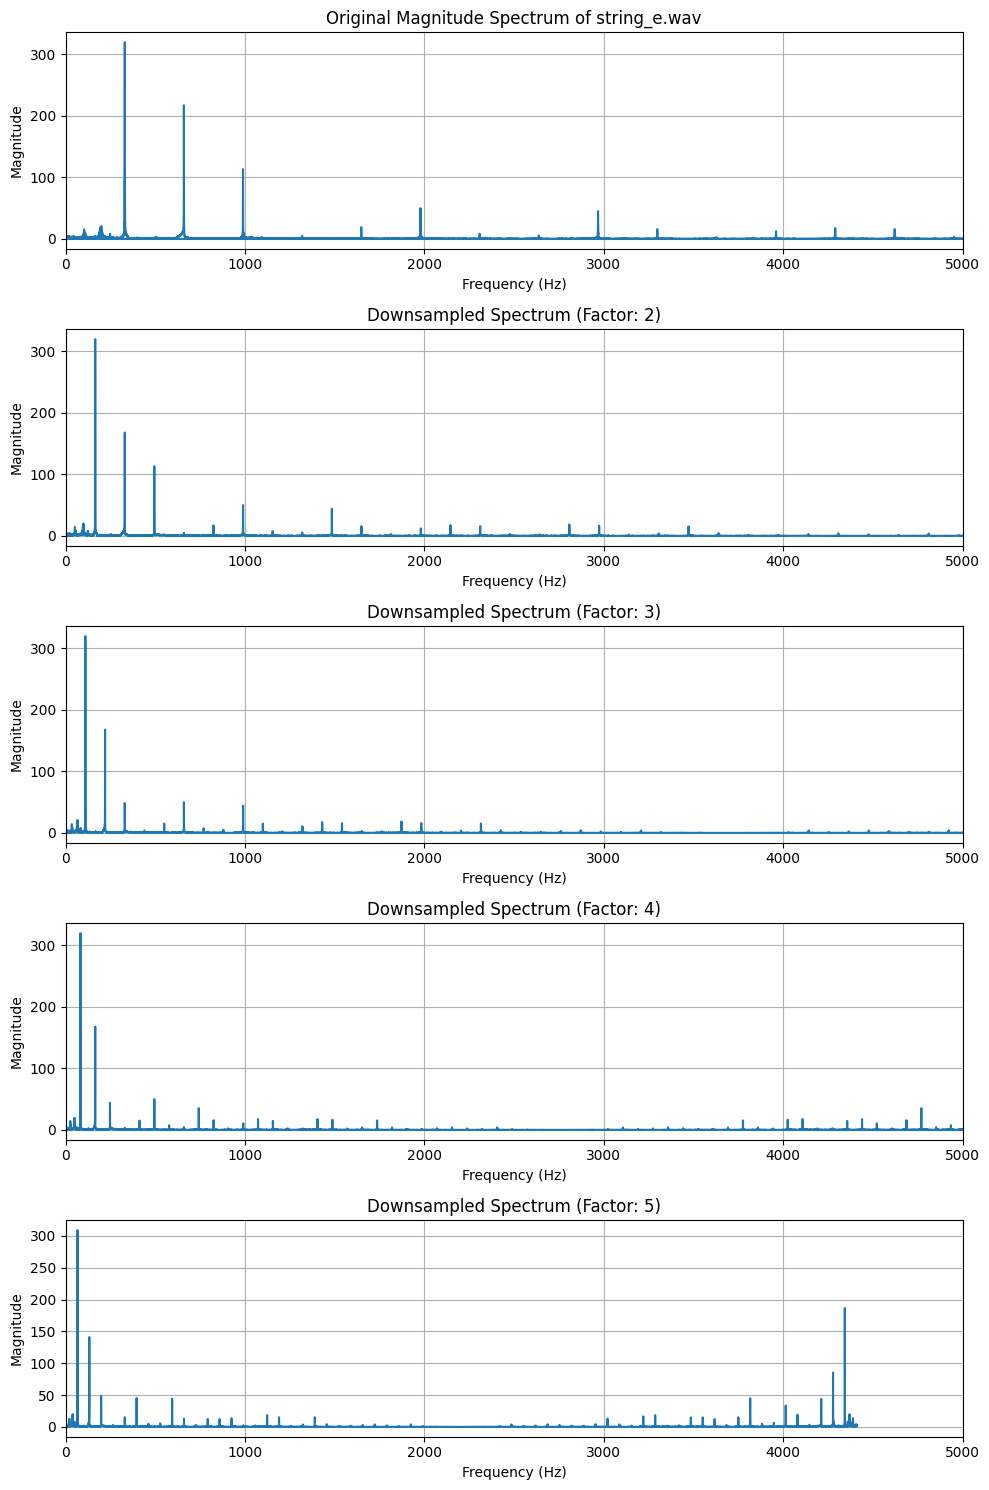

Accuracy: 0.34 Cents
Dominant Frequency: 329.68 Hz
The note is E1 (329.63 Hz)


In [9]:
peak = hps("string_e.wav")

# Print information about the dominant frequency and accuracy in cent
index, difference = find_closest_value(peak, note_frequencies)
cents_difference = difference / accuracy_cents[index]

print(f'Accuracy: {cents_difference:.2f} Cents')
print(f'Dominant Frequency: {peak:.2f} Hz')
print(f'The note is {note_names[index]} ({note_frequencies[index]} Hz)')

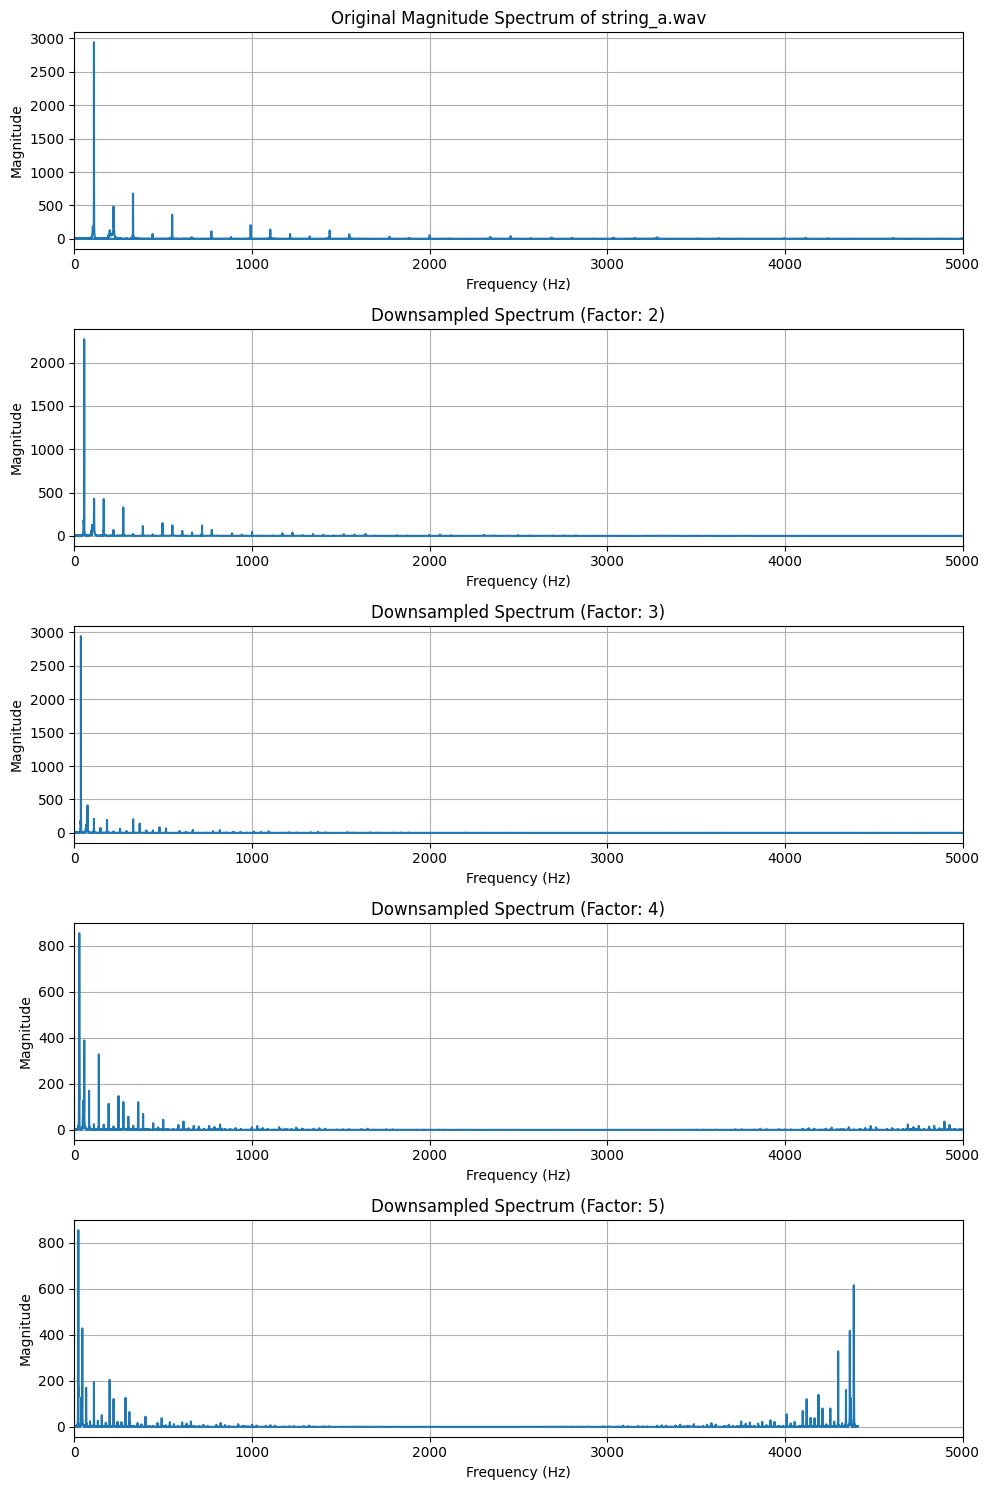

Accuracy: 1.53 Cents
Dominant Frequency: 110.12 Hz
The note is A5 (110.0 Hz)


In [10]:
peak = hps("string_a.wav")

# Print information about the dominant frequency and accuracy in cent
index, difference = find_closest_value(peak, note_frequencies)
cents_difference = difference / accuracy_cents[index]

print(f'Accuracy: {cents_difference:.2f} Cents')
print(f'Dominant Frequency: {peak:.2f} Hz')
print(f'The note is {note_names[index]} ({note_frequencies[index]} Hz)')

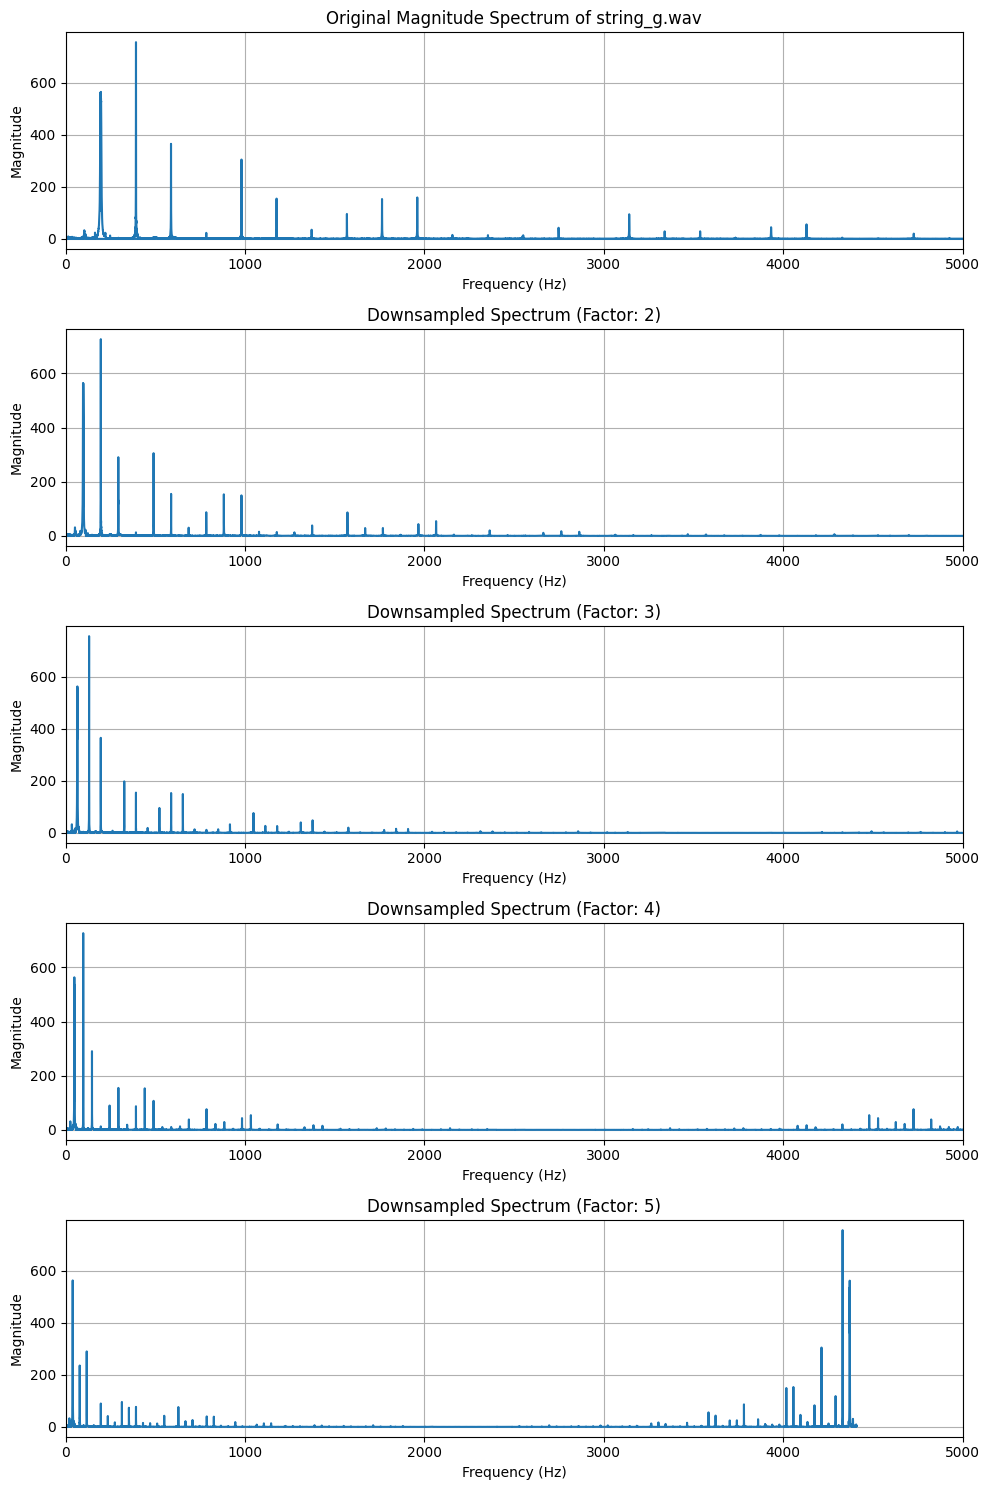

Accuracy: 0.13 Cents
Dominant Frequency: 195.98 Hz
The note is G3 (196.0 Hz)


In [11]:
peak = hps("string_g.wav")

# Print information about the dominant frequency and accuracy in cent
index, difference = find_closest_value(peak, note_frequencies)
cents_difference = difference / accuracy_cents[index]

print(f'Accuracy: {cents_difference:.2f} Cents')
print(f'Dominant Frequency: {peak:.2f} Hz')
print(f'The note is {note_names[index]} ({note_frequencies[index]} Hz)')